# Установите pytorch и pytorch3d

Лучше всего делать это с помощью conda envoronment

Инстукцию можно найти [тут](https://github.com/facebookresearch/pytorch3d/blob/main/INSTALL.md)

In [21]:
import os
import sys
import torch
import pytorch3d
import os
import torch
import matplotlib.pyplot as plt

import numpy as np
from tqdm import tqdm

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
# rendering components
from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation, 
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex, SoftPhongShader
)
import cv2
import math
from torch import nn
import torch
from pytorch3d.ops import interpolate_face_attributes
from pytorch3d.renderer.blending import hard_rgb_blend

In [22]:
def phong_normal_shading(meshes, fragments, **kwargs) -> torch.Tensor:
    faces = meshes.faces_packed()  # (F, 3)
    vertex_normals = meshes.verts_normals_packed()  # (V, 3)
    faces_normals = vertex_normals[faces]
    ones = torch.ones_like(fragments.bary_coords)
    pixel_normals = interpolate_face_attributes(
        fragments.pix_to_face, ones, faces_normals
    )
    return pixel_normals

class  NormalsShader(HardPhongShader):
    def forward(self, fragments, meshes, **kwargs) -> torch.Tensor:
        cameras = kwargs.get("cameras", self.cameras)
        if cameras is None:
            msg = "Cameras must be specified either at initialization \
                or in the forward pass of HardPhongShader"
            raise ValueError(msg)

        texels = meshes.sample_textures(fragments)
        lights = kwargs.get("lights", self.lights)
        materials = kwargs.get("materials", self.materials)
        blend_params = kwargs.get("blend_params", self.blend_params)
        colors = phong_normal_shading(
            meshes=meshes,
            fragments=fragments,
            texels=texels,
            lights=lights,
            cameras=cameras,
            materials=materials,
        )
        images = hard_rgb_blend(colors, fragments, blend_params)
        return images

In [23]:
def make_mesh(verts_3d, faces_3d, texture, faces_2d, verts_2d):
    textures = pytorch3d.renderer.mesh.textures.TexturesUV(texture, faces_2d, verts_2d)
    mesh = Meshes(
        verts=verts_3d.to(device),   
        faces=faces_3d.to(device), 
        textures=textures
    )
    return mesh

def render_mesh(mesh, distance=3, elevation=30, azimuth=0):
    
    cameras = FoVPerspectiveCameras(device=device)
    

    raster_settings = RasterizationSettings(
        image_size=256, 
        blur_radius=0.0, 
        faces_per_pixel=1, 
    )
    # We can add a point light in front of the object. 
    lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))
    phong_renderer = MeshRenderer(
        rasterizer=MeshRasterizer(
            cameras=cameras, 
            raster_settings=raster_settings
        ),
        shader=SoftPhongShader(device=device, cameras=cameras, lights=lights)
    )
    
    R, T = look_at_view_transform(distance, elevation, azimuth, device=device)

    image_ref = phong_renderer(meshes_world=dice_mesh, R=R, T=T)
    return image_ref


def render_normals(mesh, distance=3, elevation=30, azimuth=0):
    
    cameras = FoVPerspectiveCameras(device=device)
    

    raster_settings = RasterizationSettings(
        image_size=256, 
        blur_radius=0.0, 
        faces_per_pixel=1, 
    )
    # We can add a point light in front of the object. 
    lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))
    phong_renderer = MeshRenderer(
        rasterizer=MeshRasterizer(
            cameras=cameras, 
            raster_settings=raster_settings
        ),
        shader=NormalsShader(device=device, cameras=cameras, lights=lights)
    )
    
    R, T = look_at_view_transform(distance, elevation, azimuth, device=device)

    image_ref = phong_renderer(meshes_world=dice_mesh, R=R, T=T)
    return image_ref


# Задание 1: построить меш d4

Вам дана текстура игральной кости d4 (по форме представляет тетраедр):

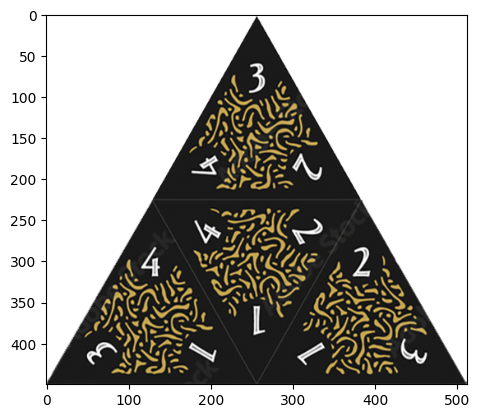

In [30]:
texture = cv2.imread('data/d4_texture.png')
texture = cv2.cvtColor(texture, cv2.COLOR_BGR2RGB) / 255
plt.imshow(texture)
plt.show()

Задача: записать
- координаты вершин тетраедра в 3D
- тройки индексов вершин, которые составляют каждую грань в 3D
- uv-координаты вершин тетраедра
- тройки индексов граней в uv-пространстве

Считайте, что длина каждого ребра равна единице

Будьте внимательны: для рендеринга мы будем использовать pytorch3d, в нем u -- это координата по горизонтали, v -- по вертикали. Также v направлена снизу вверх

<img src="data/uvexp.jpg"  width="500">

In [31]:
device = 'cuda:0'

sqrt2 = math.sqrt(2)
verts_3d = np.array([[-1.,0.,-1/sqrt2],
                [1.,0.,-1/sqrt2],
                [0.,1.,1/sqrt2],
                [0, -1, 1/sqrt2]])

faces_3d = np.array([[0,2,1],
                    [0,1,3],
                    [1,2,3],
                    [0,3,2]]).astype(np.int32)

faces_3d = faces_3d[:, [2,1,0]]

verts_2d = np.array([[0.5,1.],
                [0.25, .5],
                [0.75, .5],
                [0.5, 0.],
                [0.5, 0.],
                [1,0.]])


faces_2d = np.array([[1,4,2],
                    [1,2,0],
                    [2,4,5],
                    [1,2,3]]).astype(np.int32)

verts_3d = torch.from_numpy(verts_3d.astype(np.float32)).to(device)[None]
faces_3d = torch.from_numpy(faces_3d.astype(np.int32)).to(device)[None]
verts_2d = torch.from_numpy(verts_2d.astype(np.float32)).to(device).contiguous()[None]
faces_2d = torch.from_numpy(faces_2d.astype(np.int32)).to(device)[None]
texture = torch.from_numpy(texture.astype(np.float32)).to(device)[None]


In [32]:
print('verts_3d', faces_3d.shape, faces_3d.dtype)
print('faces_3d', verts_3d.shape, verts_3d.dtype)
print('verts_2d', verts_2d.shape, verts_2d.dtype)
print('faces_2d', faces_2d.shape, faces_2d.dtype)
print('texture', texture.shape, texture.dtype)

verts_3d torch.Size([1, 4, 3]) torch.int32
faces_3d torch.Size([1, 4, 3]) torch.float32
verts_2d torch.Size([1, 6, 2]) torch.float32
faces_2d torch.Size([1, 4, 3]) torch.int32
texture torch.Size([1, 450, 512, 3]) torch.float32


Чтобы проверить, отрендерим наш тетраедр:

+ можете изменить параметры `distance`, `elevation` и `azimuth` чтобы отрендерить с разных сторон

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


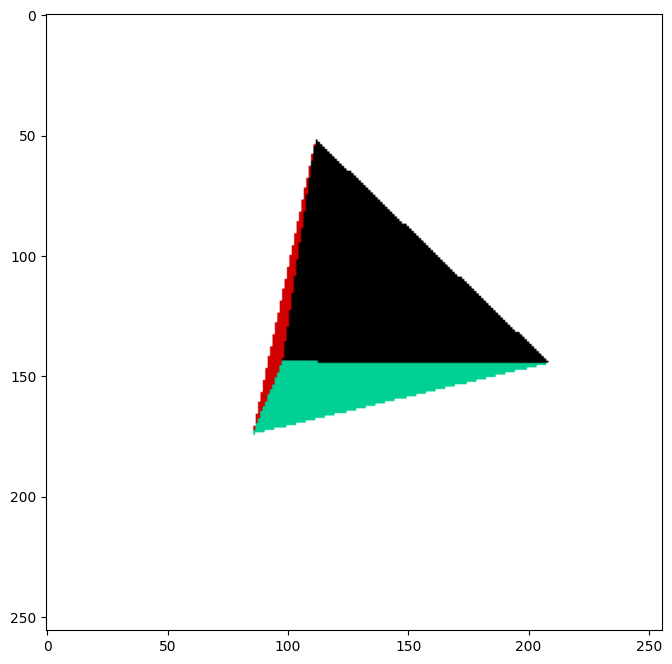

In [33]:
distance=3 # дистанция от камеры по объекта
elevation= -50 # в градусах
azimuth = 20 # в градусах

dice_mesh = make_mesh(verts_3d, faces_3d, texture, faces_2d, verts_2d)
# image_ref = render_mesh(dice_mesh, distance=distance, elevation=elevation, azimuth=azimuth)
image_ref = render_normals(dice_mesh, distance=distance, elevation=elevation, azimuth=azimuth)


image_ref_np = image_ref.cpu().numpy()
plt.figure(figsize=(8, 8))
plt.imshow(image_ref_np.squeeze())
plt.grid(False)

# Задача 2: оптимизация положения камеры

Теперь давайте попробуем, имея 2D картинку объекта, соптимизировать положение камеры относительно объекта используя дифференцируемый рендерер

Для этого будем использовать метод Soft Rendering.

Как целевую картинку будем использовать `image_ref` из предыдущего задания

Шаги
- Создать рендерер и модель используя функцию и класс ниже
- Определить попиксельные loss-функции
    - Заметьте, что у картирок есть 4й альфа-канаЛ, поэтому можно отдельно балансить лосс по RGB и по силуету
- Написать оптимизационный цикл
    - Вожможно, понадобится подобрать расписание learning rate'a
    
Из-за того что объект очень симметричный с очень регулярной формой, может быть сложно достичь идентичной картинки. Постарайтесь как минимум получить силует как на целевой картинке.

In [19]:
def make_soft_rgb_renderer(sigma=1e-4, gamma=1e-4):
    cameras = FoVPerspectiveCameras(device=device)
    blend_params = BlendParams(sigma=sigma, gamma=gamma)
    
    raster_settings = RasterizationSettings(
        image_size=256, 
        blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
        faces_per_pixel=100, 
    )
    
    lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))
    phong_renderer = MeshRenderer(
        rasterizer=MeshRasterizer(
            cameras=cameras, 
            raster_settings=raster_settings
        ),
        shader=SoftPhongShader(device=device, cameras=cameras, lights=lights)
    )
    
    return phong_renderer


In [22]:
class Model(nn.Module):
    def __init__(self, meshes, rgb_renderer):
        super().__init__()
        self.meshes = meshes
        self.device = meshes.device
        self.rgb_renderer = rgb_renderer
        
        # оптимизируемые параметры
        self.camera_position = nn.Parameter(
            torch.from_numpy(np.array([3.0,  6.9, +2.5], dtype=np.float32)).to(meshes.device))

    def forward(self):
        
        R = look_at_rotation(self.camera_position[None, :], device=self.device)  # (1, 3, 3)
        T = -torch.bmm(R.transpose(1, 2), self.camera_position[None, :, None])[:, :, 0]   # (1, 3)
        
        image_rgb = self.rgb_renderer(meshes_world=self.meshes.clone(), R=R, T=T)
        return image_rgb
  

Optimizing (loss 4994.9243):   0%|                                                                        | 0/2000 [00:00<?, ?it/s]

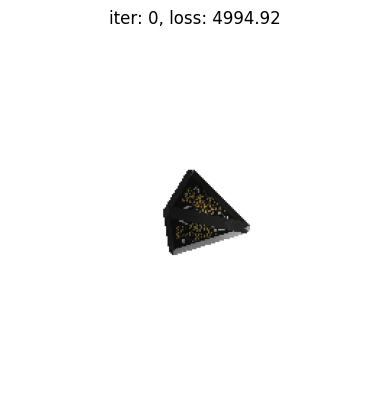

Optimizing (loss 1210.4987):   2%|█▌                                                             | 50/2000 [00:05<03:28,  9.35it/s]

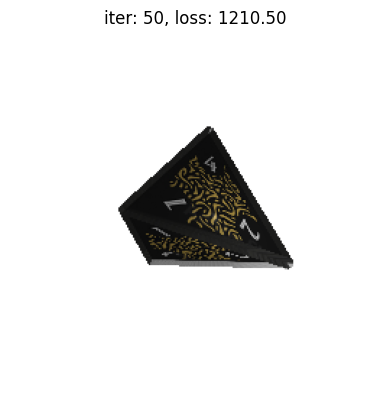

Optimizing (loss 1172.1797):   5%|███                                                           | 100/2000 [00:10<03:23,  9.33it/s]

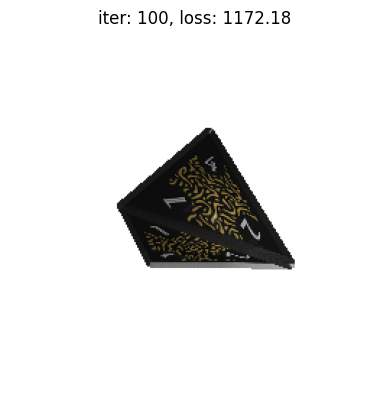

Optimizing (loss 1171.9561):   8%|████▋                                                         | 150/2000 [00:16<03:21,  9.17it/s]

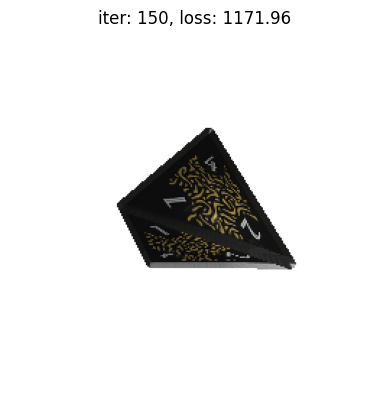

Optimizing (loss 1171.9545):  10%|██████▏                                                       | 200/2000 [00:21<03:13,  9.28it/s]

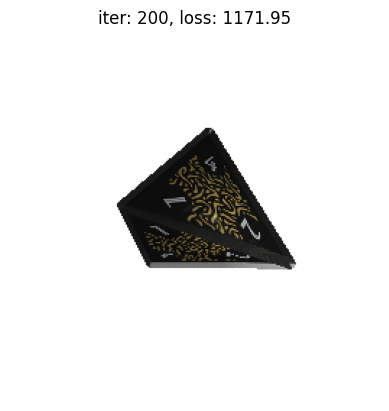

Optimizing (loss 1171.9545):  12%|███████▊                                                      | 250/2000 [00:27<03:07,  9.32it/s]

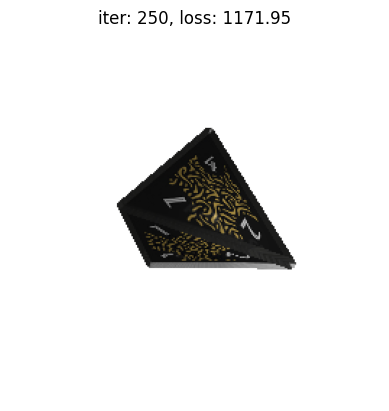

Optimizing (loss 1171.9548):  15%|█████████▎                                                    | 300/2000 [00:32<03:00,  9.44it/s]

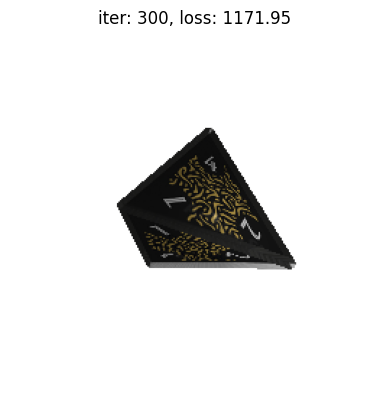

Optimizing (loss 1171.9545):  18%|██████████▊                                                   | 350/2000 [00:38<03:05,  8.91it/s]

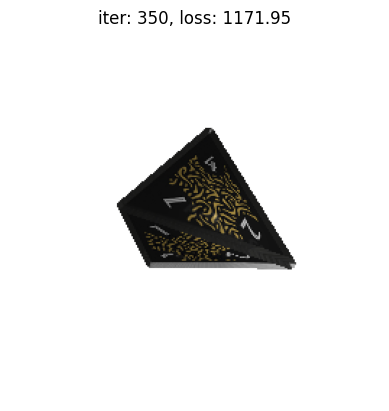

Optimizing (loss 1171.9537):  20%|████████████▍                                                 | 400/2000 [00:43<02:49,  9.45it/s]

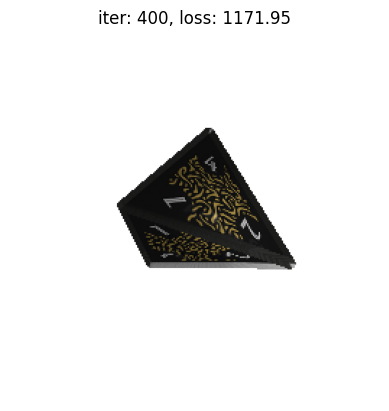

Optimizing (loss 1171.9543):  22%|█████████████▉                                                | 450/2000 [00:49<02:45,  9.38it/s]

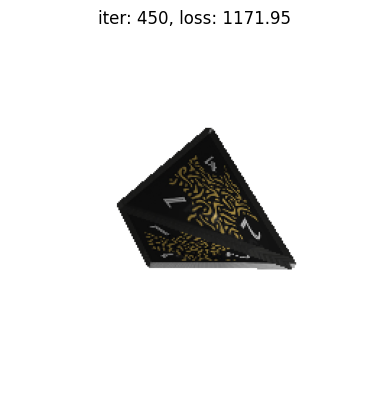

Optimizing (loss 1171.9547):  25%|███████████████▌                                              | 500/2000 [00:54<02:39,  9.39it/s]

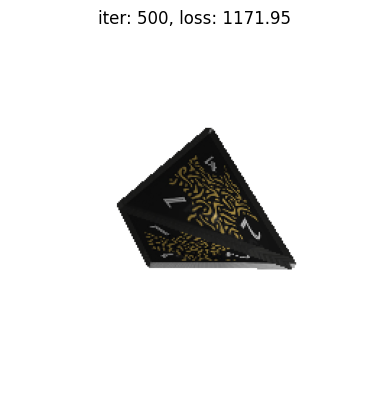

Optimizing (loss 1171.9547):  28%|█████████████████                                             | 550/2000 [01:00<02:37,  9.19it/s]

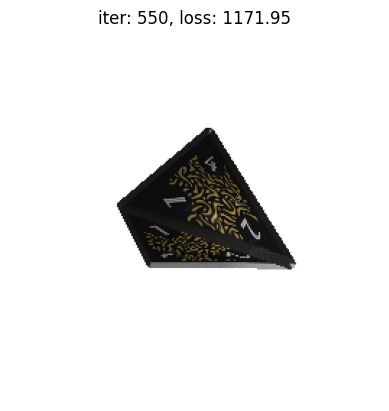

Optimizing (loss 1171.9553):  30%|██████████████████▌                                           | 600/2000 [01:05<02:28,  9.41it/s]

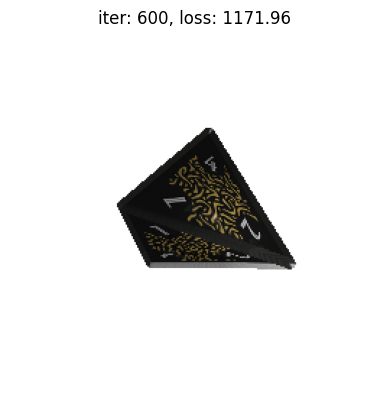

Optimizing (loss 1171.9537):  32%|████████████████████▏                                         | 650/2000 [01:10<02:24,  9.37it/s]

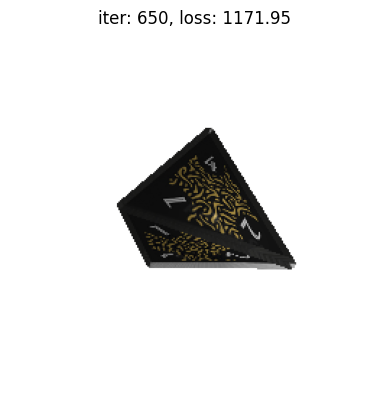

Optimizing (loss 1171.9546):  35%|█████████████████████▋                                        | 700/2000 [01:16<02:18,  9.38it/s]

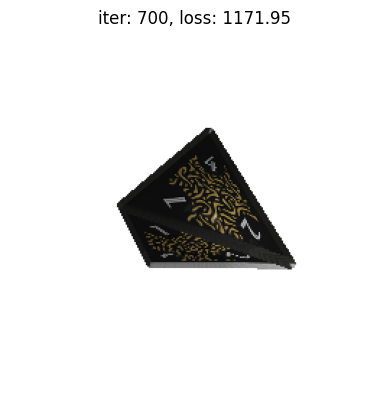

Optimizing (loss 1171.9547):  38%|███████████████████████▎                                      | 750/2000 [01:21<02:13,  9.39it/s]

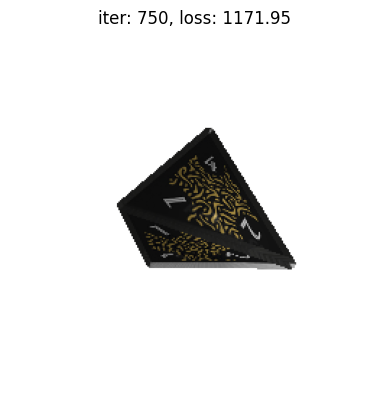

Optimizing (loss 1171.9546):  40%|████████████████████████▊                                     | 800/2000 [01:27<02:09,  9.29it/s]

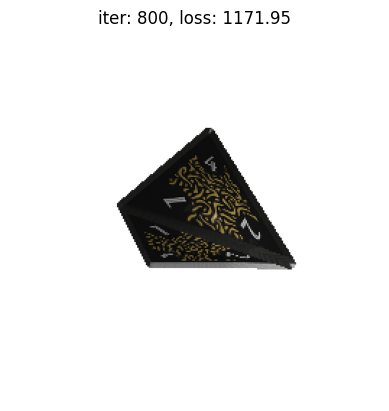

Optimizing (loss 1171.9543):  42%|██████████████████████████▎                                   | 850/2000 [01:32<02:04,  9.26it/s]

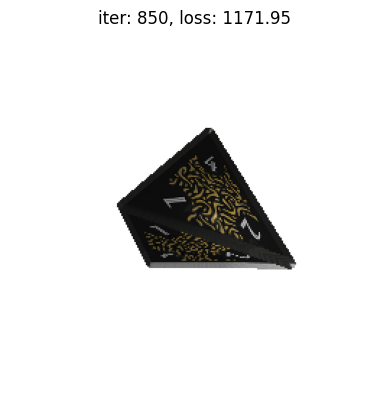

Optimizing (loss 1171.9539):  45%|███████████████████████████▉                                  | 900/2000 [01:38<01:58,  9.32it/s]

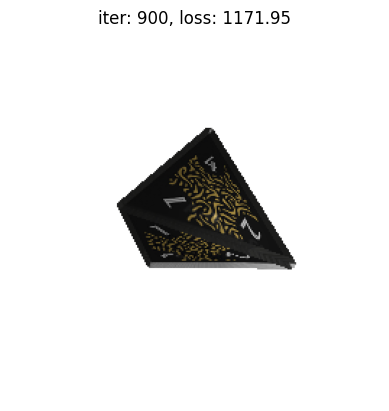

Optimizing (loss 1171.9546):  48%|█████████████████████████████▍                                | 950/2000 [01:43<01:53,  9.25it/s]

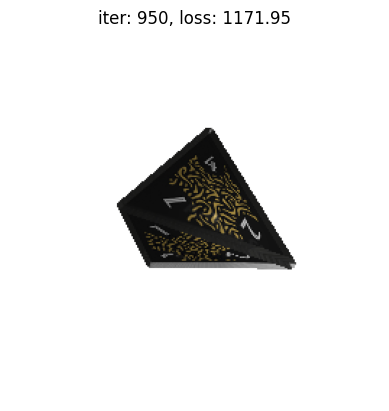

Optimizing (loss 1171.9541):  50%|██████████████████████████████▌                              | 1000/2000 [01:49<01:46,  9.35it/s]

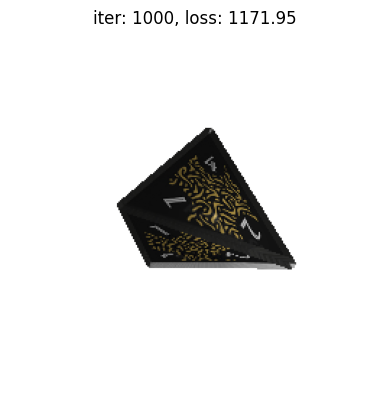

Optimizing (loss 1171.9541):  52%|████████████████████████████████                             | 1050/2000 [01:54<01:43,  9.21it/s]

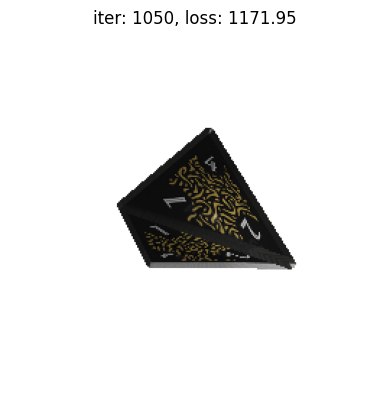

Optimizing (loss 1171.9539):  55%|█████████████████████████████████▌                           | 1100/2000 [02:00<01:35,  9.46it/s]

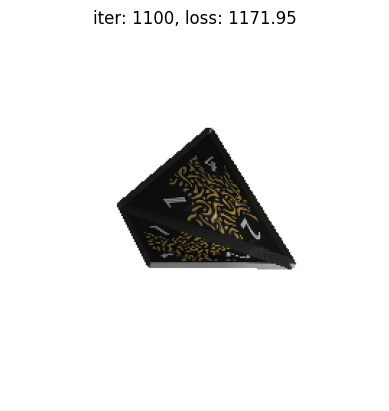

Optimizing (loss 1171.9545):  57%|███████████████████████████████████                          | 1150/2000 [02:05<01:29,  9.45it/s]

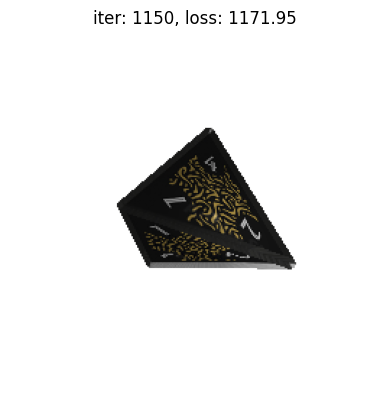

Optimizing (loss 1171.9542):  60%|████████████████████████████████████▌                        | 1200/2000 [02:10<01:26,  9.28it/s]

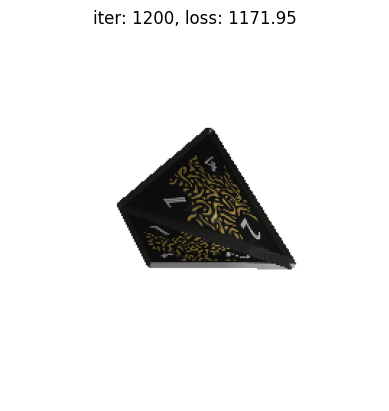

Optimizing (loss 1171.9561):  62%|██████████████████████████████████████▏                      | 1250/2000 [02:16<01:22,  9.13it/s]

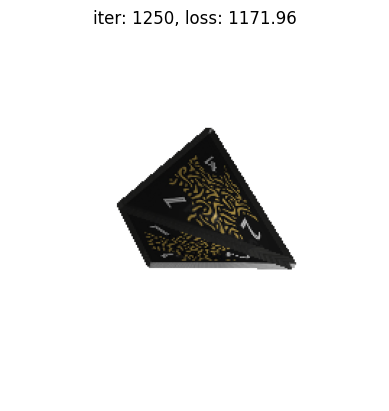

Optimizing (loss 1171.9541):  65%|███████████████████████████████████████▋                     | 1300/2000 [02:21<01:17,  9.06it/s]

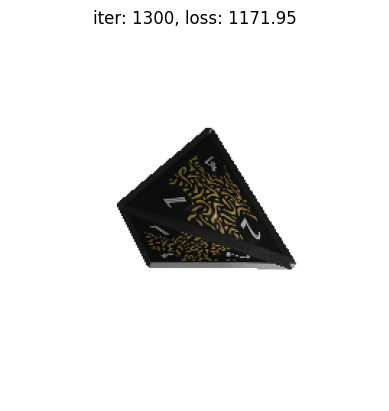

Optimizing (loss 1171.9550):  68%|█████████████████████████████████████████▏                   | 1350/2000 [02:27<01:10,  9.19it/s]

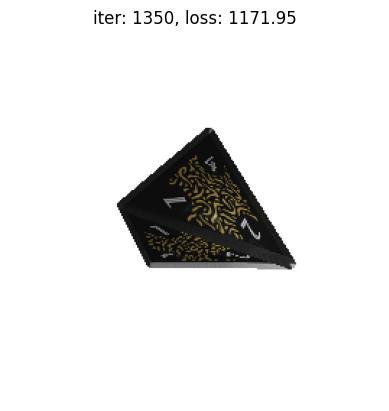

Optimizing (loss 1171.9542):  70%|██████████████████████████████████████████▋                  | 1400/2000 [02:32<01:05,  9.19it/s]

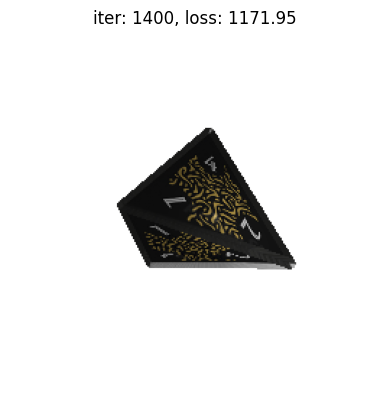

Optimizing (loss 1171.9542):  72%|████████████████████████████████████████████▏                | 1450/2000 [02:38<00:57,  9.49it/s]

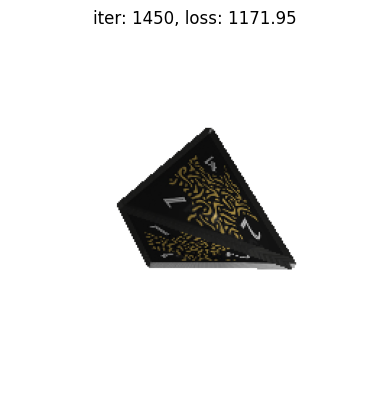

Optimizing (loss 1171.9548):  75%|█████████████████████████████████████████████▊               | 1500/2000 [02:43<00:54,  9.12it/s]

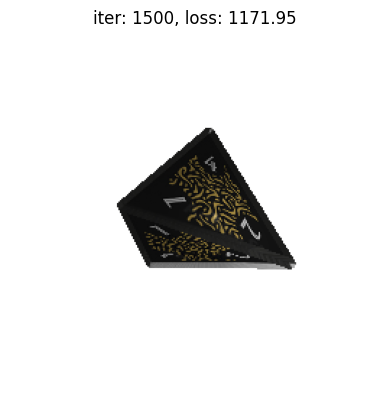

Optimizing (loss 1171.9541):  78%|███████████████████████████████████████████████▎             | 1550/2000 [02:49<00:47,  9.45it/s]

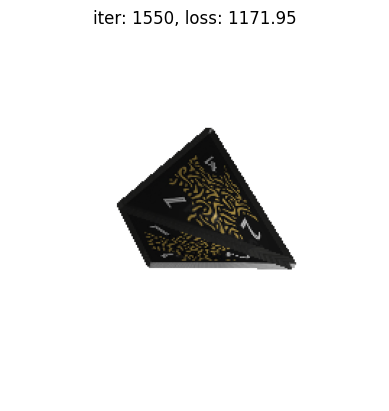

Optimizing (loss 1171.9541):  80%|████████████████████████████████████████████████▊            | 1600/2000 [02:54<00:42,  9.41it/s]

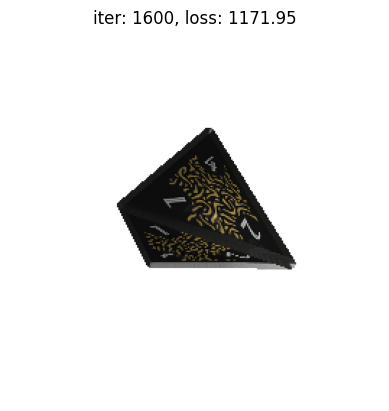

Optimizing (loss 1171.9546):  82%|██████████████████████████████████████████████████▎          | 1650/2000 [02:59<00:37,  9.42it/s]

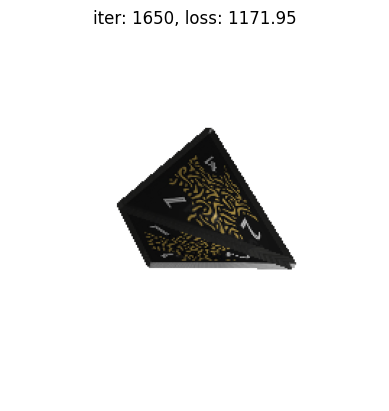

Optimizing (loss 1171.9553):  85%|███████████████████████████████████████████████████▊         | 1700/2000 [03:05<00:31,  9.49it/s]

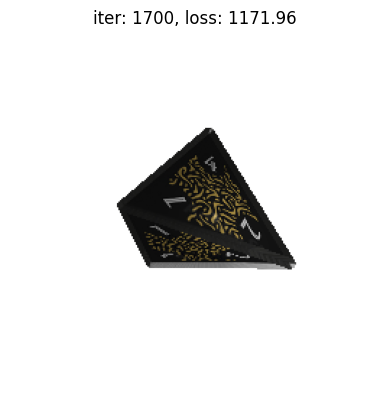

Optimizing (loss 1171.9545):  88%|█████████████████████████████████████████████████████▍       | 1750/2000 [03:10<00:26,  9.45it/s]

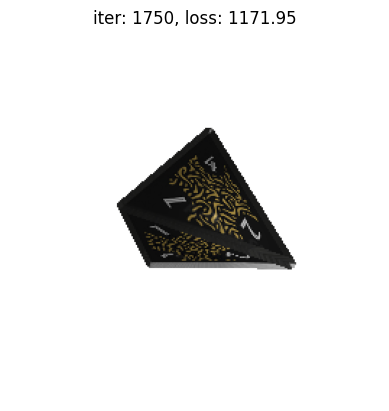

Optimizing (loss 1171.9542):  90%|██████████████████████████████████████████████████████▉      | 1800/2000 [03:16<00:21,  9.33it/s]

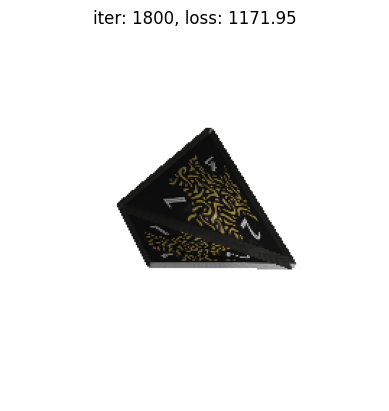

Optimizing (loss 1171.9550):  92%|████████████████████████████████████████████████████████▍    | 1850/2000 [03:21<00:15,  9.42it/s]

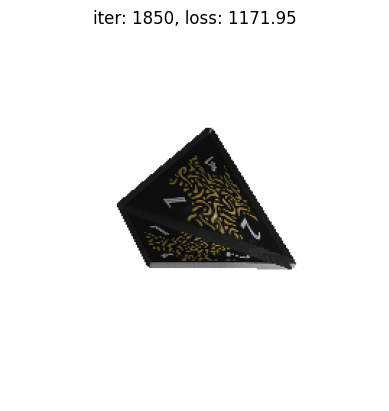

Optimizing (loss 1171.9550):  95%|█████████████████████████████████████████████████████████▉   | 1900/2000 [03:26<00:10,  9.10it/s]

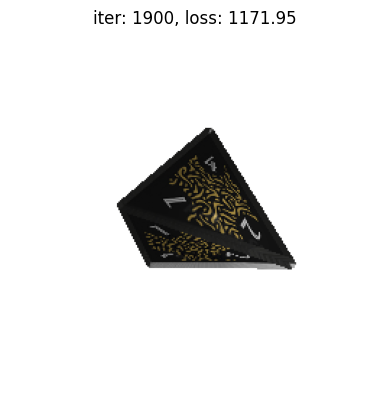

Optimizing (loss 1171.9548):  96%|██████████████████████████████████████████████████████████▌  | 1920/2000 [03:29<00:08,  9.27it/s]

In [ ]:
rgb_renderer = make_soft_rgb_renderer(sigma=1e-4, gamma=1e-4)
model = Model(dice_mesh, rgb_renderer)

# model = Model(meshes=dice_mesh, renderer=phong_renderer, image_ref=image_ref).to(device)
# model = Model(meshes=dice_mesh, renderer=phong_renderer, image_ref=image_ref).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
max_iter = 2000
lr_ramp = 0.1
def sc_f(it):
    l = lr_ramp**(float(it)/float(max_iter))
    # print(it, l)
    return l

scheduler    = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=sc_f)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

loop = tqdm(range(max_iter))
for i in loop:
    optimizer.zero_grad()
    
    rgba_image = model()
    rgb_image = rgba_image[..., :3]
    opacity = rgba_image[..., 3:]
    
    rgb_loss = (rgb_image - image_ref[..., :3]).pow(2).sum()
    silh_loss = (opacity - image_ref[..., 3:]).pow(2).sum()
    
    loss = silh_loss #+ rgb_loss
    
    loss.backward()
    optimizer.step()
    # scheduler.step()
    loop.set_description('Optimizing (loss %.4f)' % loss.data)
    
    if loss.item() < 200:
        break
    
    # Save outputs to create a GIF. 
    if i % 50 == 0:
        R = look_at_rotation(model.camera_position[None, :], device=model.device)
        T = -torch.bmm(R.transpose(1, 2), model.camera_position[None, :, None])[:, :, 0]   # (1, 3)
        image = rgb_renderer(meshes_world=model.meshes.clone(), R=R, T=T)
        image = image[0, ..., :3].detach().squeeze().cpu().numpy()
        
        plt.figure()
        plt.imshow(image[..., :3])
        plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
        plt.axis("off")
        plt.show()

# Задание 3 (со звёздочкой): нейронные текстуры

- Склоньте репозиторий [Neural Textures](https://github.com/Dolorousrtur/neural-textures)
- По инструкции в README.md постройте докер контейнер и скачайте данные
- Используя код из `render_azure_person.py` и `utils/demo.py` в ноутбуке
    - достаньте пресохранённую нейронную текстуру (см. `utils/demo.py:L101`)
    - отрисуйте её первые 3 канала
    - Затем сделайте нейронный рендер (см. `utils/demo.py:L99,107`) и тоже отрисуйте его первые 3 канала
    - Пропустите нейрорендер сквозб рендерющую сеть, чтобы получить RGB картинку `utils/demo.py:L109,114`)